## Spatial interpolation for EPA AQI

Last updated on 07/06/2023


This notebook demonstrates the spatial interpolation of the EPA real-time air quality monitoring data from AirNow API: https://docs.airnowapi.org/

User-defined variables

In [1]:
# Data csv file
infile = 'drive/MyDrive/epa_chicago_20230626.csv'
# Grid and domainfile
gridfile = 'drive/MyDrive/grid.pkl'

## Google Colab Environment

In [2]:
pip install ipyleaflet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00


In [3]:
pip install gpcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.2/285.2 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/593.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 55.6 MB/s eta 0:00:00
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha256=61b5f739b563cd1d72b169b364cda3f13621e910918a1c8685d1cce5ef8e3fe6
  Stored in

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load Data

In [5]:
import pandas as pd
import pickle

In [6]:
df = pd.read_csv(infile)

In [7]:
f = open(gridfile,"rb")
grid = pickle.load(f)
f.close()

## Map Visualization

In [8]:
from ipyleaflet import Map
from ipyleaflet import basemaps
from ipyleaflet import (Map, basemaps, WidgetControl, GeoJSON,
                        LayersControl, Icon, Marker,FullScreenControl,
                        CircleMarker, Popup, AwesomeIcon)
from ipywidgets import HTML
import matplotlib.pyplot as plt
import matplotlib as mpl

In [9]:
def plotmapAQI(metric,df,center,zoom):
    df = df.reindex(columns = df.columns.tolist()+ ['color'])
    # Determine color depending on the values
    color=[]
    # Scaling the values
    for (i,j) in df.iterrows():
        value=j[metric]
        if value<=50:
            color.append('green')
        elif(value>50 and value<=100):
            color.append('yellow')
        elif(value>100 and value<=150):
            color.append('orange')
        elif(value>150 and value<=200):
            color.append('red')
        else:
            color.append('darkred')
    df['color']=color
    # Map
    center = center
    zoom = zoom
    i=0
    m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
    # Add markers
    for (index,row) in df.iterrows():
        loc = [row.loc['Latitude'],row.loc['Longitude']]
        #icon = AwesomeIcon(
        #         marker_color='red')
        # marker = Marker(location=loc, icon, draggable=False,alt='alt')
        # marker.color = 'red'
        marker = CircleMarker()
        marker.location = loc
        marker.radius = 5
        marker.color = row.loc['color']
        marker.fill_color = row.loc['color']

        m.add_layer(marker);
        # Pop up
        message = HTML()
        message.value = 'Location:'+str(row.loc['Latitude'])+','+str(row.loc['Longitude'])+', Value:'+str(row.loc[metric])
        marker.popup = message

        i+=1
    m.add_control(FullScreenControl())
    mpl.rcParams.update({'font.size': 10})
    fig=plt.figure(figsize=(8,3))
    ax=fig.add_subplot(111)
    vals=[]
    for i in range(6):
        vals.append((((250)/5)*i)+0)
    cmap = mpl.colors.ListedColormap(['green','yellow','orange','red','darkred'])
    norm = mpl.colors.BoundaryNorm(vals, cmap.N)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
    cb.set_label(metric)
    ax.set_position((0.1, 0.45, 0.8, 0.1))
    return m

Map(center=[42.8172225, -87.39416800000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

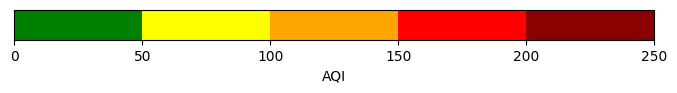

In [11]:
metric = "AQI"
plotmapAQI(metric,df,grid['center'],7)

## Interpolation by GPCAM

In [12]:
import gpcam
from gpcam.autonomous_experimenter import AutonomousExperimenterGP
from gpcam.gp_optimizer import GPOptimizer

import numpy as np

In [49]:
# Define the kernel/covariance
def kernel_RBF_noise(x1, x2, hps, obj):
    var = hps[0]
    noise_var = hps[3]
    d1 = abs(np.subtract.outer(x1[:, 0], x2[:, 0]))
    d2 = abs(np.subtract.outer(x1[:, 1], x2[:, 1]))
    d = ((d1/hps[1])**2 + (d2/hps[2])**2)**0.5
    K = var * np.exp(-d ** 2)
    if x1 is x2:
        return K + noise_var * np.eye(K.shape[0])
    else:
        return K

In [14]:
x = np.column_stack((np.array(df['Latitude']),np.array(df['Longitude'])))

In [50]:
x_train = x
y_train = np.array(df['AQI'])

param_bounds = np.array([[x_train[:,0].min(), x_train[:,0].max()],
                [x_train[:,1].min(), x_train[:,1].max()]])
init_hp = np.array([np.var(y_train),2.0,2.0, np.var(y_train)*0.01])
hp_bounds = np.array([[np.var(y_train)*0.9,np.var(y_train)*1.1],[0.5,3.0],[0.5,3.0],[np.var(y_train)*0.009,np.var(y_train)*0.015]])

In [51]:
my_ae = AutonomousExperimenterGP(param_bounds,
                                 init_hp,
                                 hp_bounds,
                                 init_dataset_size= 100,
                                 x_data=x_train,
                                 y_data=y_train,
                                 kernel_func = kernel_RBF_noise,
                                 use_inv = True,
                                 communicate_full_dataset = False,
                                 ram_economy = True)#, info = False, prior_mean_func = optional_mean_func)
my_ae.train(max_iter=10000)

In [52]:
xx = np.column_stack((grid['xx0'].flatten(),grid['xx1'].flatten()))
f = my_ae.gp_optimizer.posterior_mean(xx)["f(x)"].reshape(grid['n_pts'])
v = my_ae.gp_optimizer.posterior_covariance(xx)["v(x)"].reshape(grid['n_pts'])
np.save(infile+'.npy',f)

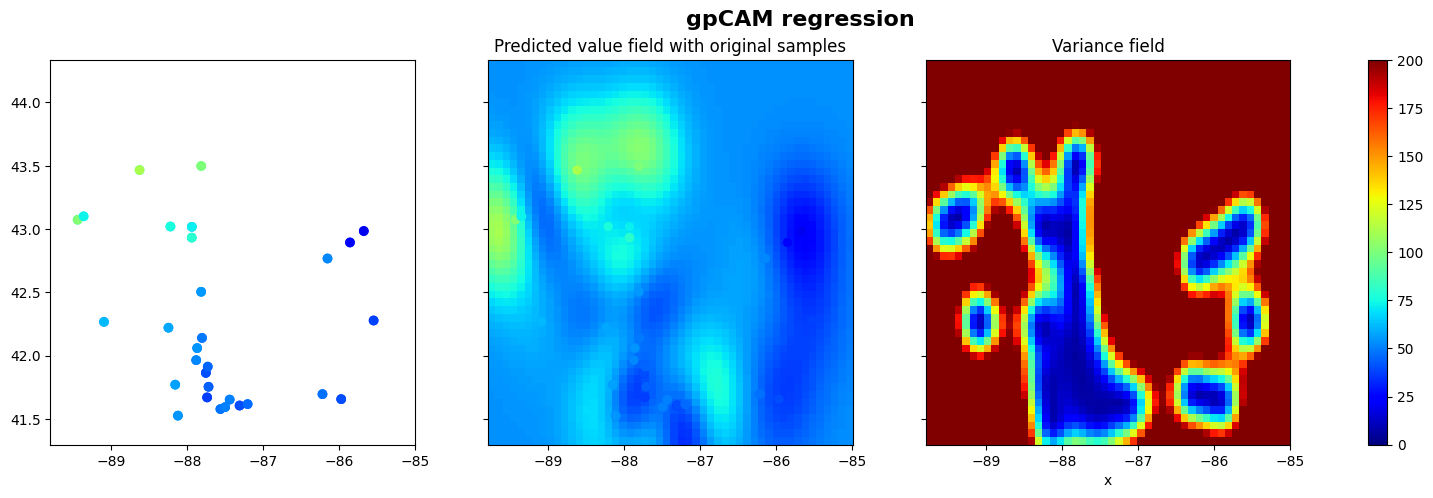

In [53]:
# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharex=True, sharey=True)

# Original values
axs[0].scatter(x[:,1], x[:,0], c=y_train, cmap="jet",vmin=0, vmax=200)

# Predicted value field
s1 = axs[1].pcolormesh(grid['xx1'], grid['xx0'], f, cmap="jet",vmin=0, vmax=200)
axs[1].scatter(x[:, 1], x[:, 0], c=y_train, cmap="jet",vmin=0, vmax=200)
axs[1].set_title(f'Predicted value field with original samples')

# Variance field
s2 = axs[2].pcolormesh(grid['xx1'], grid['xx0'], v, cmap="jet",vmin=0, vmax=200)
axs[2].set_title(f'Variance field')
axs[2].set_xlabel('x')

# Create a single colorbar for all subplots
fig.colorbar(s1, ax=axs)

# Set title for the entire figure
fig.suptitle(f'gpCAM regression', fontsize=16, fontweight='bold')
plt.show()

## Overlay with Map

In [54]:
from base64 import b64encode
from io import StringIO, BytesIO
import PIL
from ipyleaflet import Map, ImageOverlay

In [55]:
f = (f-np.min(f))/(np.max(f)-np.min(f))
f = np.transpose(f)
f = np.flipud(f)
f_im = PIL.Image.fromarray(np.uint8(plt.cm.jet(f) * 255))
im = PIL.Image.new("RGBA", f.shape, color=None)
im.paste(f_im)

In [56]:
fio = BytesIO()
im.save(fio, "png")
data = b64encode(fio.getvalue())
data = data.decode("ascii")
imgurl = "data:image/png;base64," + data

In [57]:
m = Map(center=grid['center'], zoom=7)
image = ImageOverlay(
    url=imgurl,
    bounds=((grid['sw'][0],grid['sw'][1]), (grid['ne'][0],grid['ne'][1])),
    opacity=0.3
)

m.add_layer(image);
m

Map(center=[42.8172225, -87.39416800000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…